# Phase 2 (2.1, 2.2, 2.3)

## Imports, data loading

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime
import math
import pandas as pd

 
from matplotlib import pyplot as plt

We decided to not use one-shot encoding for any of the columns because we lack domain specific knowledge and do not know all possible value of any categorical column - ie, we cannot be sure if the sets are closed.

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
base_dir = os.path.join("..")
dataset_dir = os.path.join(base_dir, "dataset")

connections_path = os.path.join(dataset_dir, "connections.csv")
devices_path = os.path.join(dataset_dir, "devices.csv")
processes_path = os.path.join(dataset_dir, "processes.csv")
profiles_path = os.path.join(dataset_dir, "profiles.csv")

In [4]:
connections = pd.read_csv(connections_path, date_format='%Y-%m-%d %H:%M:%S', parse_dates=["ts"], sep="\t")
devices = pd.read_csv(devices_path, sep="\t")
processes = pd.read_csv(processes_path, date_format='%Y-%m-%d %H:%M:%S', parse_dates=["ts"], sep="\t")
profiles = pd.read_csv(profiles_path, sep="\t")

### Data Preparation

We have made some changes from the faza1 and clean some data before Processing of data.
The devices dataset is sorted by the store_name column, because we see a lot of duplicates with one Profile for many imei code.
After sorting, it removes duplicate entries based on the imei column, keeping only the first occurrence of each unique imei value. 


In [5]:
devices = devices.sort_values(by='store_name', ascending=False)
devices = devices.drop_duplicates(subset='imei', keep="first")

In [6]:
profiles

,birthdate,username,address,current_location,company,registration,name,imei,residence,user_id,mail,ssn
0,NaN,leeashley,USNV Ward\nFPO AA 23732,"(Decimal('28.417152'), Decimal('-25.410694'))",Acosta-English,06 Nov 2020,William Robinson,863033069630348701,NaN,73,stevenwilson@yahoo.com,801-95-4729
1,NaN,michael57,"4369 Smith Corners Apt. 253\nNorth Adamview, S...","(Decimal('-33.164854'), Decimal('166.295349'))","Fitzgerald, Valdez and Hardy",12 Oct 2018,Heather Miranda,8630330696303481214,"2929 Bird Orchard\nHodgesville, HI 51906",2373,nicolechavez@yahoo.com,175-40-3979
2,2012-05-29,tina84,NaN,"(Decimal('-59.4063945'), Decimal('-120.967605'))",Kent-Proctor,2022/12/25,Joyce Taylor,3590433799317662402,"599 Burns Highway\nWest John, OR 32130",1433,dominic60@hotmail.com,574-27-4206
3,NaN,michelle69,"682 Burns Pike Suite 462\nSouth Kelly, SD 18911","(Decimal('-20.7762805'), Decimal('1.752069'))",Hughes PLC,2021-01-13,Patrick Roth,863033069630348651,NaN,348,rschaefer@yahoo.com,732-09-7190
4,NaN,kim64,"198 Wood Way Suite 529\nChristopherburgh, WA 4...","(Decimal('-61.6858245'), Decimal('-152.512503'))","Woodward, Smith and Morris",2019-06-05,Danielle Pierce,8630330696303482014,NaN,198,fgray@hotmail.com,202-62-6122
...,...,...,...,...,...,...,...,...,...,...,...,...
2620,2003-08-28,nroach,NaN,NaN,Chase-Rodriguez,2022-01-25,Michael Baxter,3590433799317661214,"483 Nicholas Spring\nVelezmouth, OK 25264",2014,acoleman@hotmail.com,067-12-6446
2621,1989-07-22,ojohnson,"987 Jennifer Groves Suite 003\nRachelville, WA...","(Decimal('-86.038002'), Decimal('156.354173'))","Acosta, Smith and Collins","11/19/2018, 00:00:00",Wendy Crane,8630330696303481420,"77547 Ryan Glen\nNew Lisaport, KS 64929",1385,kruegerjessica@yahoo.com,280-11-6465
2622,NaN,armstrongangel,NaN,"(Decimal('27.2379175'), Decimal('85.402468'))","Bass, Brown and Webb",04 Apr 2021,Gina Sweeney,3590433799317661669,Unit 9404 Box 0430\nDPO AP 90322,306,veronica02@hotmail.com,604-12-8359
2623,1978-07-03,michaelsmith,"5356 Thomas Shore\nHinesland, IL 91614","(Decimal('79.6959655'), Decimal('163.837298'))","Burton, Bullock and Davis","10/08/2022, 00:00:00",Christy Miller,8630330696303481198,"64513 Larson Crest Apt. 727\nBryantbury, SD 85098",405,bwhite@yahoo.com,155-73-9021


In [7]:
# Since we have already had location in the dataset, we don't need string address, so we will drop it.
profiles.drop(columns=["address"], inplace=True)

#Same is for location in devices dataset. It is not necessary info coz we already have this info.
devices.drop(columns=["location"], inplace=True)

In [8]:
# Formatting data format function
def parse_date(date_str):
    date_formats = [
        "%d %b %Y",           # e.g., 12 Oct 2018
        "%Y/%m/%d",           # e.g., 2022/12/25
        "%Y-%m-%d",           # e.g., 2021-01-13
        "%m/%d/%Y, %H:%M:%S", # e.g., 05/12/2021, 00:00:00
        "%m/%d/%Y",           # e.g., 04/25/2023
        "%d %b %Y, %H:%M:%S", # e.g., 24 Aug 2023, 00:00:00
    ]
    for fmt in date_formats:
        try:
            return datetime.strptime(date_str, fmt).strftime("%Y-%m-%d")
        except ValueError:
            continue
    return None  # Return None if the date format is unrecognized


# Parse and convert 'registration' to datetime, coercing invalid entries to NaT
profiles['registration'] = profiles['registration'].apply(parse_date)
profiles['registration'] = pd.to_datetime(profiles['registration'], errors='coerce')

# Impute missing 'birthdate' with mode, parse, and convert to datetime with coercion
birthdate_mode = profiles['birthdate'].mode()[0]
profiles.fillna({'birthdate': birthdate_mode}, inplace=True)

profiles['birthdate'] = profiles['birthdate'].apply(parse_date)
profiles['birthdate'] = pd.to_datetime(profiles['birthdate'], errors='coerce')

In [9]:
# Fill missing 'address' with 'Unknown' and flag missing 'residence' as 1 (missing) or 0 (present)
profiles.fillna({'address': 'Unknown'}, inplace=True)
profiles['residence'] = profiles['residence'].isna().astype("int8")

# Impute missing 'birthdate' with the mode
birthdate_mode = profiles['birthdate'].mode()[0]
profiles.fillna({'birthdate': birthdate_mode}, inplace=True)

In [10]:
# Remove dashes from 'ssn' and convert it to an integer
profiles['ssn'] = profiles['ssn'].str.replace('-', '', regex=False).astype("int64")

In [11]:
# Function to parse 'current_location' into latitude and longitude
def parse_location(location):
    if location == "Unknown" or pd.isnull(location):
        return None, None
    try:
        lat, lon = location[1:-1].split(", ")
        lat = float(lat.replace("Decimal('", "").replace("')", ""))
        lon = float(lon.replace("Decimal('", "").replace("')", ""))
        return lat, lon
    except:
        return None, None
    
    
# Apply 'parse_location' to split 'current_location' into new latitude and longitude columns
# profiles[['cur_loc_latitude', 'cur_loc_longitude']] = profiles['current_location'].apply(lambda x: pd.Series(parse_location(x)))

# Drop the original 'current_location' column after parsing
profiles = profiles.drop(columns=['current_location'])

# Calculate the mean latitude and longitude and fill missing values with these means
# lat_mean = profiles['cur_loc_latitude'].mean()
# lon_mean = profiles['cur_loc_longitude'].mean()
# profiles.fillna({'o.cur_loc_latitude': lat_mean}, inplace=True)
# profiles.fillna({'o.cur_loc_longitude': lon_mean}, inplace=True)

In [12]:
# Remove duplicate rows from each dataset to ensure unique entries
connections.drop_duplicates(inplace = True)
processes.drop_duplicates(inplace = True)
devices.drop_duplicates(inplace = True)
profiles.drop_duplicates(inplace = True)

We convert text columns (username, mail, name) into numeric metrics (spaces, vowels, length) to make the data more structured and suitable for analysis. It then removes unnecessary metrics, like spaces in mail and username, which have limited analytical value.

In [13]:
# Function to calculate the specified metrics
def calculate_metrics(text):
    spaces = text.count(' ')
    vowels = sum(1 for char in text.lower() if char in 'aeiou')
    length = len(text)
    return pd.Series([spaces, vowels, length])

def replace_col_with_metrics(df, column):    
    metrics = df[column].apply(calculate_metrics).astype("float64")
    metrics.columns = [f'm.{column}_spaces', f'm.{column}_vowels', f'm.{column}_length']
    return pd.concat([df.drop(columns=[column]), metrics], axis=1)

# Apply the function to each specified column
for column in ['username', 'mail', 'name']:
    profiles = replace_col_with_metrics(profiles, column)

profiles.drop(columns=['m.mail_spaces', 'm.username_spaces'], inplace = True)

We will count of occurrences for each unique imei, and show the distribution of these frequencies, indicating how many IMEIs appear with a specific repetition count. 
his helps identify the extent of duplication for imei values across profiles.

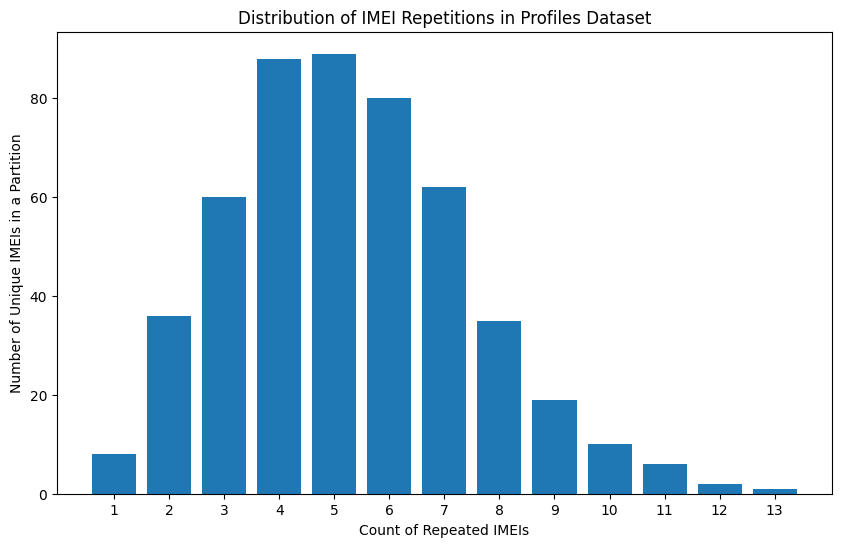

In [14]:
# Calculate imei repetition counts
imei_counts = profiles['imei'].value_counts()

# Count of IMEI repetition frequencies (i.e., how many IMEIs have the same count)
count_of_counts = imei_counts.value_counts()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(count_of_counts.index, count_of_counts.values)
plt.xlabel('Count of Repeated IMEIs')
plt.ylabel('Number of Unique IMEIs in a Partition')
plt.title('Distribution of IMEI Repetitions in Profiles Dataset')
plt.xticks(count_of_counts.index)
plt.show()

This is a problem, because if we join it to the rest of the tables, we will overrepresent some entries
Out solution is to set repetetion to 7 - so all partition of < 7 entries would get duplicated, and all > 7 will be randomly
truncated

In [15]:
# Set the target number of rows per 'imei' value.
target_count = 7

# Function to balance rows for each 'imei'
def balance_imei_rows(group):
    count = len(group)
    if count > target_count:
        # If the group has more rows than the target, randomly sample down to the target count.
        return group.sample(target_count, random_state=1)  
    else:
        # If the group has fewer rows, duplicate rows to reach the target count.
        repeats = target_count // count
        extra = target_count % count
        # Combine repeated rows with a sample for the remainder.
        balanced_group = pd.concat([group] * repeats + [group.sample(extra, random_state=1)])
        return balanced_group

# Apply the balancing function to each group and combine results
profiles = profiles.set_index('imei').groupby('imei', group_keys=False).apply(balance_imei_rows).reset_index()

So, now we are ensured that each imei group in profiles has exactly 7 rows by truncating excess rows or duplicating smaller groups to meet the target. It’s helpful for creating a balanced dataset by standardizing the number of entries per imei.

### Join datasets
We will perform outer join between 'connections' and 'processes' on 'imei' and 'ts'. An outer join is used here to keep all matching and non-matching rows across both datasets.
Then we'll merge the result with 'devices' and 'profiles' on 'imei' using an inner join. This keeps only the rows where 'imei' exists in both merged_data and devices with profiles.

In [16]:
merged_pc = pd.merge(connections, processes, on=['imei', 'ts'], how='outer')
merged_pcd = pd.merge(merged_pc, devices, on=['imei'], how='inner')
merged_data = pd.merge(merged_pcd, profiles, on='imei', how='inner')

merged_data

,ts,imei,mwra_x,c.android.gm,c.android.youtube,c.dogalize,c.katana,c.android.chrome,c.android.vending,c.UCMobile.intl,c.updateassist,c.raider,c.UCMobile.x86,mwra_y,p.android.documentsui,p.system,p.android.externalstorage,p.android.gm,p.android.chrome,p.android.settings,p.android.packageinstaller,p.simulator,p.android.gms,p.android.vending,p.dogalize,p.katana,p.google,p.process.gapps,p.gms.persistent,p.android.defcontainer,p.inputmethod.latin,p.olauncher,p.browser.provider,p.notifier,latitude,longitude,store_name,code,birthdate,company,registration,residence,user_id,ssn,m.username_vowels,m.username_length,m.mail_vowels,m.mail_length,m.name_spaces,m.name_vowels,m.name_length
0,2018-05-05 12:23:00,359043379931766007,0.0,14.52938,7.71307,10.08484,10.58818,9.42769,0.00633,46.38676,70.25169,50.05013,46.04899,0.0,10.60034,8.11579,12.24666,12.08060,11.14452,13.21121,7.94409,38.92799,55.13217,49.05971,19.76232,81.94569,65.71934,75.81309,23.58062,30.95626,23.87663,20.89900,73.66048,31.31086,39.22493,42.85693,Patnos,TR,1929-12-06,"Cole, Butler and Benjamin",2021-11-13,1,2267,397153910,4.0,12.0,7.0,22.0,2.0,5.0,18.0
1,2018-05-05 12:23:00,359043379931766007,0.0,14.52938,7.71307,10.08484,10.58818,9.42769,0.00633,46.38676,70.25169,50.05013,46.04899,0.0,10.60034,8.11579,12.24666,12.08060,11.14452,13.21121,7.94409,38.92799,55.13217,49.05971,19.76232,81.94569,65.71934,75.81309,23.58062,30.95626,23.87663,20.89900,73.66048,31.31086,39.22493,42.85693,Patnos,TR,1929-12-06,Cameron Ltd,2024-05-31,1,2617,574380086,2.0,10.0,7.0,19.0,1.0,3.0,13.0
2,2018-05-05 12:23:00,359043379931766007,0.0,14.52938,7.71307,10.08484,10.58818,9.42769,0.00633,46.38676,70.25169,50.05013,46.04899,0.0,10.60034,8.11579,12.24666,12.08060,11.14452,13.21121,7.94409,38.92799,55.13217,49.05971,19.76232,81.94569,65.71934,75.81309,23.58062,30.95626,23.87663,20.89900,73.66048,31.31086,39.22493,42.85693,Patnos,TR,1929-12-06,"Cole, Butler and Benjamin",2021-11-13,1,2267,397153910,4.0,12.0,7.0,22.0,2.0,5.0,18.0
3,2018-05-05 12:23:00,359043379931766007,0.0,14.52938,7.71307,10.08484,10.58818,9.42769,0.00633,46.38676,70.25169,50.05013,46.04899,0.0,10.60034,8.11579,12.24666,12.08060,11.14452,13.21121,7.94409,38.92799,55.13217,49.05971,19.76232,81.94569,65.71934,75.81309,23.58062,30.95626,23.87663,20.89900,73.66048,31.31086,39.22493,42.85693,Patnos,TR,1929-12-06,Cameron Ltd,2024-05-31,1,2617,574380086,2.0,10.0,7.0,19.0,1.0,3.0,13.0
4,2018-05-05 12:23:00,359043379931766007,0.0,14.52938,7.71307,10.08484,10.58818,9.42769,0.00633,46.38676,70.25169,50.05013,46.04899,0.0,10.60034,8.11579,12.24666,12.08060,11.14452,13.21121,7.94409,38.92799,55.13217,49.05971,19.76232,81.94569,65.71934,75.81309,23.58062,30.95626,23.87663,20.89900,73.66048,31.31086,39.22493,42.85693,Patnos,TR,1929-12-06,"Cole, Butler and Benjamin",2021-11-13,1,2267,397153910,4.0,12.0,7.0,22.0,2.0,5.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102650,2018-05-15 11:25:00,8630330696303482493,1.0,11.46839,8.34700,8.24165,7.56971,8.23698,0.00488,73.87256,48.78442,1.32542,16.83306,1.0,10.34440,9.52914,15.92803,14.52519,10.83273,12.19045,7.34970,30.06252,52.72453,39.71483,10.61216,70.87827,36.35082,54.31963,33.86918,42.42220,39.15254,37.63967,28.68696,94.86824,57.97472,33.25250,Valday,RU,1929-12-06,"Spencer, Acosta and Dickerson",2018-05-25,1,1804,261193064,4.0,10.0,6.0,23.0,1.0,4.0,15.0
102651,2018-05-15 11:25:00,8630330696303482493,1.0,11.46839,8.34700,8.24165,7.56971,8.23698,0.00488,73.87256,48.78442,1.32542,16.83306,1.0,10.34440,9.52914,15.92803,14.52519,10.83273,12.19045,7.34970,30.06252,52.72453,39.71483,10.61216,70.87827,36.35082,54.31963,33.86918,42.42220,39.15254,37.63967,28.68696,94.86824,57.97472,33.25250,Valday,RU,1929-12-06,Martin-Gonzalez,2022-03-04,1,769,300842191,2.0,7.0,9.0,27.0,1.0,3.0,11.0
102652,2018-05-15 11:25:00,8630330696303482493,1.0,11.46839,8.3470

**Note on Join Strategy:**
Inner joins are used throughout to ensure only rows with matching entries in all tables are included.
Although a "proper" solution would use left joins to retain more data, it would require handling NaN values.
Given the dataset size, the loss of around 350 entries is minimal (approximately 0.5% of 100,000 / 7 after balancing).


In [17]:
# Start with left join between 'merged_pc' and 'devices' to retain unmatched 'imei' entries in merged_pc. 
demonstrate_proper_data = pd.merge(merged_pc, devices, on=['imei'], how='left')
# Perform another left join with 'profiles' to retain all entries from the previous merge. 
demonstrate_proper_data = pd.merge(demonstrate_proper_data, profiles, on='imei', how='left')

# This shows the number of rows where either 'code' or 'user_id' is missing after left joins.
print("Count the rows with missing 'code' or 'user_id' values due to unmatched entries in the left join: ", 
      len(demonstrate_proper_data[demonstrate_proper_data["code"].isna()]) + len(demonstrate_proper_data[demonstrate_proper_data["user_id"].isna()]))

Count the rows with missing 'code' or 'user_id' values due to unmatched entries in the left join:  786


**Merging Strategy:**
Inner joins are used initially to ensure the final merged_data only contains fully matched rows across all datasets. This approach is efficient, especially when data completeness is more important than including all potential entries.

**Alternative with Left Joins:**
Left joins allow more entries to be retained, even if there are missing values in some columns. However, handling the resulting NaN values would require additional processing. The commented example demonstrates this approach, with the final print statement showing the number of rows with missing values in code and user_id.

Since only a small fraction of data is lost by using inner joins, this method is acceptable, balancing simplicity with minimal data loss.

Now let's merge the two mwra columns created from a merge operation, preserving only one consistent mwra column, and removes the redundant columns afterward. Then rename columns with adding .o like (other) for future analyzing. Also, we will drop useless columns. 

Also, we'll process and transform datetime columns in merged_data for feature extraction and standardization. This includes extracting hour, determining weekend status, converting dates to ordinal format, and renaming columns to maintain consistent naming conventions. 

In [18]:
# Combine 'mwra_x' and 'mwra_y' columns into a single 'mwra' column, prioritizing non-null values in 'mwra_x' using combine_first.
merged_data['o.mwra'] = merged_data['mwra_x'].combine_first(merged_data['mwra_y'])
# Drop the original 'mwra_x' and 'mwra_y' columns to remove redundancy now that they are combined into 'mwra'.
merged_data.drop(columns=['mwra_x', 'mwra_y'], inplace=True)

# Rename columns to ensure consistency, adding an 'o.' (other) prefix to indicate processed fields.
merged_data.rename(columns = {'ts': 'o.ts', 
                           'birthdate': 'o.birthdate', 
                           'registration': 'o.registration',                           
                           'residence': 'o.residence',
                           'code': 'o.code',
                           'company': 'o.company',
                          }, inplace=True)

# Let's drop imei column coz we don't need it for predictions
merged_data = merged_data.drop(columns=["imei"])
# We do not need those too, as we try not to memorize some bad users, but to analyze the activity
merged_data = merged_data.drop(columns=["user_id", "ssn", "store_name"])

There are many devices and profiles with the same imei. We can do nothing about multiple devices, so it multiplies everything. But! We can do something about profiles. 
This is invalid for ts to be less then registration for joined row - how can you generate data before you even registered? 
We will replace bad profiles with mean info.

This code cleans up invalid profile data (where activity timestamps are before registration dates) by replacing invalid values with average values derived from valid profiles. It ensures consistency and prevents logically impossible data (e.g., generating data before registering) from skewing the dataset. Duplication is purposefully retained to handle multiple profiles for the same IMEI.

In [19]:
# Identify rows with valid profiles by checking if 'o.registration' is before or equal to 'o.ts'
# (i.e., the timestamp of the activity should not be earlier than the registration date).
valid_profiles_idx = merged_data['o.registration'] <= merged_data['o.ts']

# Filter out rows with valid profiles only, where registration is on or before the activity timestamp.
valid_profiles = merged_data[valid_profiles_idx]

# Calculate the mean values for location-related profile columns ('cur_loc_latitude', 'cur_loc_longitude')
# based only on valid profiles to get typical (average) profile data.
# profile_means = valid_profiles[['cur_loc_latitude', 'cur_loc_longitude']].mean()

# Select additional columns (like metrics starting with 'm.' or profile-specific columns such as 'o.residence'
# and 'o.birthdate') and calculate their means on valid rows, creating representative values for invalid profiles.
filtered_columns = [col for col in merged_data.columns if col.startswith('m.') or col == 'o.birthdate']
profile_means2 = valid_profiles[filtered_columns].mean()

profile_medians = valid_profiles[['o.residence']].median()

# Ensure that invalid profile rows have consistent, representative data by replacing them with calculated means.
merged_data = merged_data.copy()  # Create a copy to prevent modifications on the original reference.
# Replace invalid 'cur_loc_latitude' and 'cur_loc_longitude' with the calculated mean values from valid profiles.
# for col in profile_means.index:
#     merged_data.loc[~valid_profiles_idx, col] = profile_means[col]
for col in profile_means2.index:
    merged_data.loc[~valid_profiles_idx, col] = profile_means2[col]
# Replace invalid entries in other profile-specific columns with their mean values, ensuring consistency.
for col in profile_medians.index:
    merged_data.loc[~valid_profiles_idx, col] = profile_medians[col]

# Note: Duplicate rows are intentionally left intact to handle multiple profile records with the same IMEI,
# so we do not drop duplicates here. The duplication addresses multiple profiles tied to the same IMEI.
# # combined = combined2.drop_duplicates()


### Splitting data

In [20]:
from sklearn.model_selection import train_test_split

# Define the split ratio (e.g., 80% for training, 20% for testing)
train_ratio = 0.8

# Split the data
train_data, test_data = train_test_split(merged_data, test_size=1 - train_ratio, random_state=1)

In [21]:
# Save the dataset to .csv
# merged_data.to_csv('merged_data.csv', index=False)
# train_data.to_csv("train_data.csv", index=False)
# test_data.to_csv("test_data.csv", index=False)

### Pipelines

The DataProcessingTransformer class is a custom sklearn transformer designed to preprocess a DataFrame by performing several feature transformations on date-related columns and memory optimizations for numeric columns. It ensures consistency across date formats and derives useful features like hour and weekend indicators.

The GridBinningTransformer class designed to transforme class bins latitude and longitude coordinates into grid cells based on specified numbers of bins for latitude (n_lat_bins) and longitude (n_lon_bins). It then calculates unique grid indices for both device and current locations, filling any missing values with the median grid index.

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

class GridBinningTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_lat_bins=16, n_lon_bins=8):
        self.n_lat_bins = n_lat_bins
        self.n_lon_bins = n_lon_bins

    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self 
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def transform(self, X):
        # Copy the DataFrame to avoid modifying the original data
        X = X.copy()
        
        # Discretize latitude and longitude into bins for device and current location
        X['lat_bin'] = pd.cut(X['latitude'], bins=self.n_lat_bins, labels=False)
        X['lon_bin'] = pd.cut(X['longitude'], bins=self.n_lon_bins, labels=False)
        X['cur_loc_latitude_bin'] = pd.cut(X['cur_loc_latitude'], bins=self.n_lat_bins, labels=False)
        X['cur_loc_longitude_bin'] = pd.cut(X['cur_loc_longitude'], bins=self.n_lon_bins, labels=False)
        
        # Calculate unique grid index for each area
        X['o.dev_loc_grid_idx'] = X['lat_bin'] * self.n_lon_bins + X['lon_bin']
        X['o.cur_loc_grid_idx'] = X['cur_loc_latitude_bin'] * self.n_lon_bins + X['cur_loc_longitude_bin']
        
        # Fill NaN values in grid indices with the median value of non-null indices
        X.fillna({'o.dev_loc_grid_idx': X['o.dev_loc_grid_idx'].median()}, inplace=True)
        X.fillna({'o.cur_loc_grid_idx': X['o.cur_loc_grid_idx'].median()}, inplace=True)
        
        # Drop intermediate columns if only grid indices are needed
        X.drop(columns=['lat_bin', 'lon_bin', 'cur_loc_latitude_bin', 'cur_loc_longitude_bin',
                        'latitude', 'longitude', 'cur_loc_latitude', 'cur_loc_longitude'], inplace=True)
        
        return X

The LogTransformerWithZeroHandling class applies a log transformation to a specified column, replacing zero values with 1 to avoid undefined log(0).

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class LogTransformerWithZeroHandling(BaseEstimator, TransformerMixin):
    """
    A transformer that applies a log transformation, replacing zero values with one to avoid log(0).
    Useful for handling columns where log transformation is desired but contains zeros.
    """
    def __init__(self):
        pass
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self

    def transform(self, X):
        X = X.copy() 
        X[X == 0] = 1 
        X = X.apply(np.log)
        
        return X

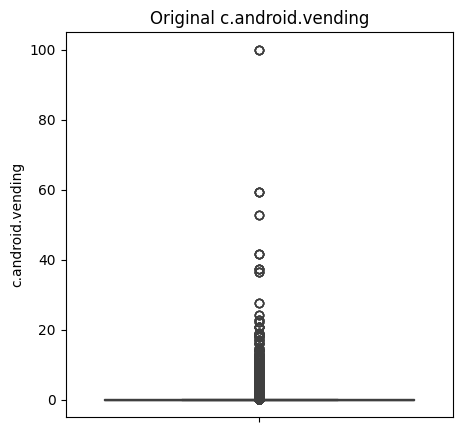

In [24]:
# We have notice bad data for this attribute: c.adroid.vending looks logarithmic
# Draw boxplot for the 'c.android.vending' column
plt.figure(figsize=(5, 5))
sns.boxplot(data=train_data, y='c.android.vending')
plt.title("Original c.android.vending")
plt.show()

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin

class ClippingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=5, upper_percentile=95):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_

    def fit(self, X, y=None):
        # Calculate the percentiles for each feature
        self.columns_ = X.columns
        self.lower_bounds_ = np.percentile(X, self.lower_percentile, axis=0)
        self.upper_bounds_ = np.percentile(X, self.upper_percentile, axis=0)
        return self

    def transform(self, X):
        # Clip the data within the calculated percentiles
        X_clipped = np.clip(X, self.lower_bounds_, self.upper_bounds_)
        return X_clipped


In [26]:
from sklearn.base import BaseEstimator, TransformerMixin

class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self
    
    def get_feature_names_out(self, *args, **params):
        return self.columns_
        
    def transform(self, X):
        # Ensure the input is a DataFrame
        X = X.copy()
        for col in X.columns:
            X[col] = pd.to_datetime(X[col]).map(lambda x: x.toordinal())
        
        return X

In [27]:
pcs = [col for col in train_data.columns if col.startswith('p.') or col.startswith('c.')] # all attributes from processing and connection dataset


In [29]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OrdinalEncoder, RobustScaler

p1 = ColumnTransformer([
    ('log_transform_vending', LogTransformerWithZeroHandling(), ['c.android.vending']),
], remainder='passthrough', verbose_feature_names_out=False)

p2 = ColumnTransformer([
    ('clipping', ClippingTransformer(), pcs),
    ('dates', DateTransformer(), ['o.birthdate', 'o.registration', 'o.ts']),
], remainder='passthrough', verbose_feature_names_out=False)

p3 = ColumnTransformer([
    ('scaling_pcs', RobustScaler(), pcs),
    ('minmax', MinMaxScaler(), ["o.birthdate"]),
    ('categorical_encoding', OrdinalEncoder(), ["o.code", "o.company"])
], remainder='passthrough', verbose_feature_names_out=False)

preprocessing_pipeline = Pipeline([('phase1', p1), ('phase2', p2), ('phase3', p3)])

df = train_data
# df = GridBinningTransformer(n_lat_bins=16, n_lon_bins=8).fit_transform(df)
dfc = df.copy()
df = preprocessing_pipeline.set_output(transform="pandas").fit_transform(df)

# Test the pipeline on the sample data
transformed_data = df

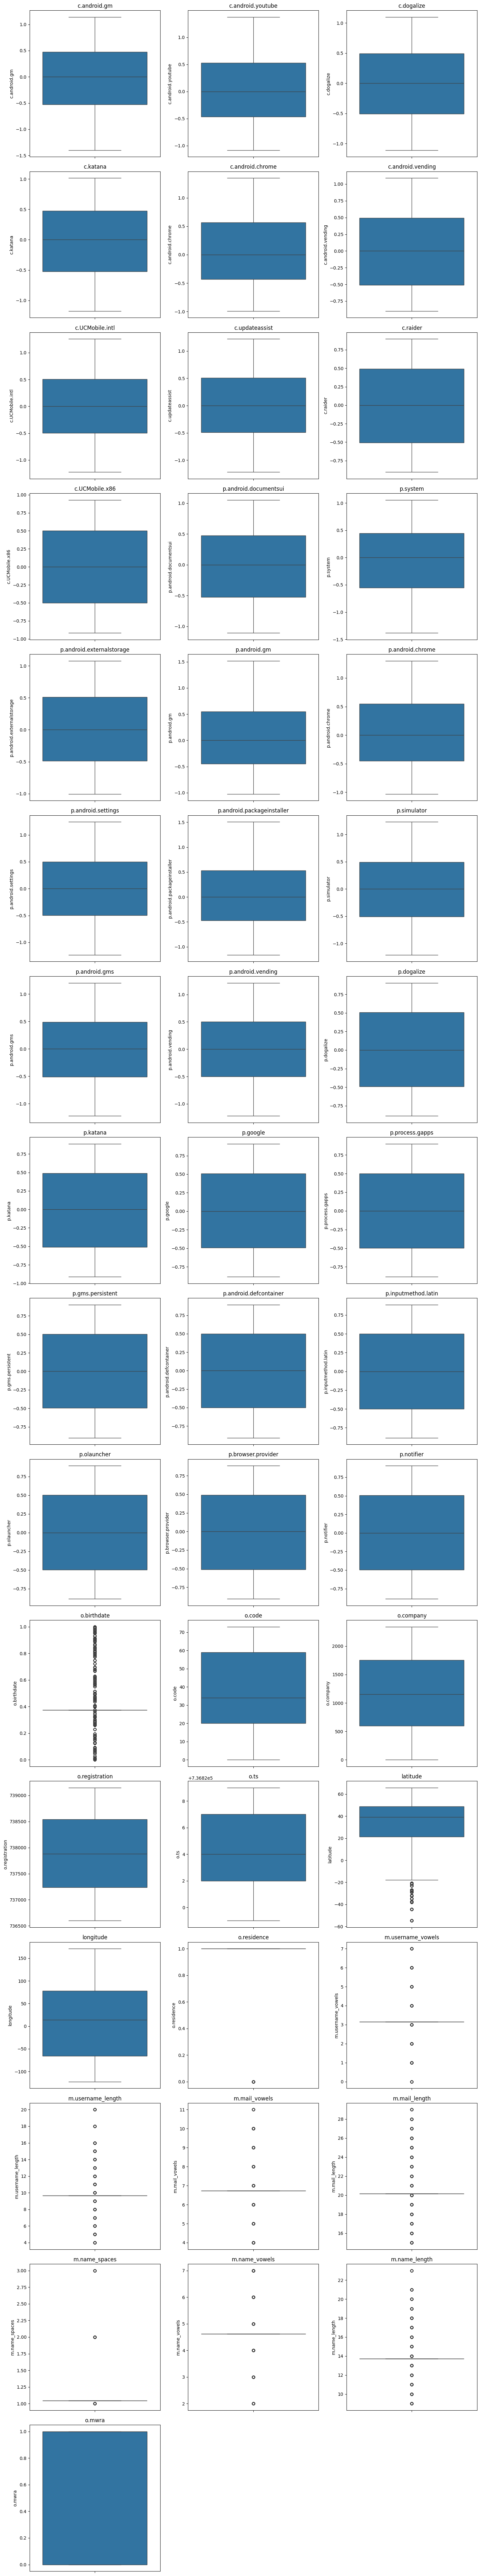

In [30]:

columns = df.columns
n_cols = 3
n_rows = math.ceil(len(columns) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), squeeze=False)

for i, col in enumerate(columns):
    row, col_num = divmod(i, n_cols)
    sns.boxplot(data=df, y=col, ax=axes[row][col_num])
    axes[row][col_num].set_title(col)

for j in range(i + 1, n_rows * n_cols):
    row, col_num = divmod(j, n_cols)
    fig.delaxes(axes[row][col_num])

plt.tight_layout()
plt.show()

This code uses a Random Forest classifier to identify the most informative features for predicting a target variable. The data is split into features (X) and target (y), and a Random Forest model is trained on this data. After training, the feature importances—indicating each feature’s predictive power—are extracted, sorted, and displayed. Model performance is evaluated using accuracy and AUROC, providing metrics for classification quality. A horizontal bar plot visually highlights the most influential features, emphasizing those with the highest importance for interpretation.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

df = transformed_data.copy()
X = transformed_data.drop(columns=['o.mwra']) 
y = transformed_data['o.mwra']

model = RandomForestClassifier(random_state=42) 
model.fit(X, y)

# Get the importance of the traits
importances = model.feature_importances_

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Desc sort
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Accuracy evaluation on the training set
pred_y = model.predict(X)
print("Unique prediction values: ", np.unique(pred_y))
print("Model accuracy:", accuracy_score(y, pred_y))

# AUROC evaluation
prob_y = model.predict_proba(X)
prob_y = [p[1] for p in prob_y] # Probabilities for the positive class
print("AUROC: ", roc_auc_score(y, prob_y))

# Display the importance table
print(feature_importance)

Unique prediction values:  [0. 1.]
Model accuracy: 1.0
AUROC:  1.0
                       Feature  Importance
14            p.android.chrome    0.137401
4             c.android.chrome    0.132122
10       p.android.documentsui    0.112332
5            c.android.vending    0.099029
16  p.android.packageinstaller    0.058254
0                 c.android.gm    0.055226
1            c.android.youtube    0.034503
11                    p.system    0.033287
13                p.android.gm    0.029961
2                   c.dogalize    0.029011
12   p.android.externalstorage    0.027782
3                     c.katana    0.022686
15          p.android.settings    0.014780
35                    latitude    0.011088
9               c.UCMobile.x86    0.010894
21                    p.katana    0.010520
36                   longitude    0.010514
24            p.gms.persistent    0.010459
25      p.android.defcontainer    0.010410
7               c.updateassist    0.010330
26         p.inputmethod.latin

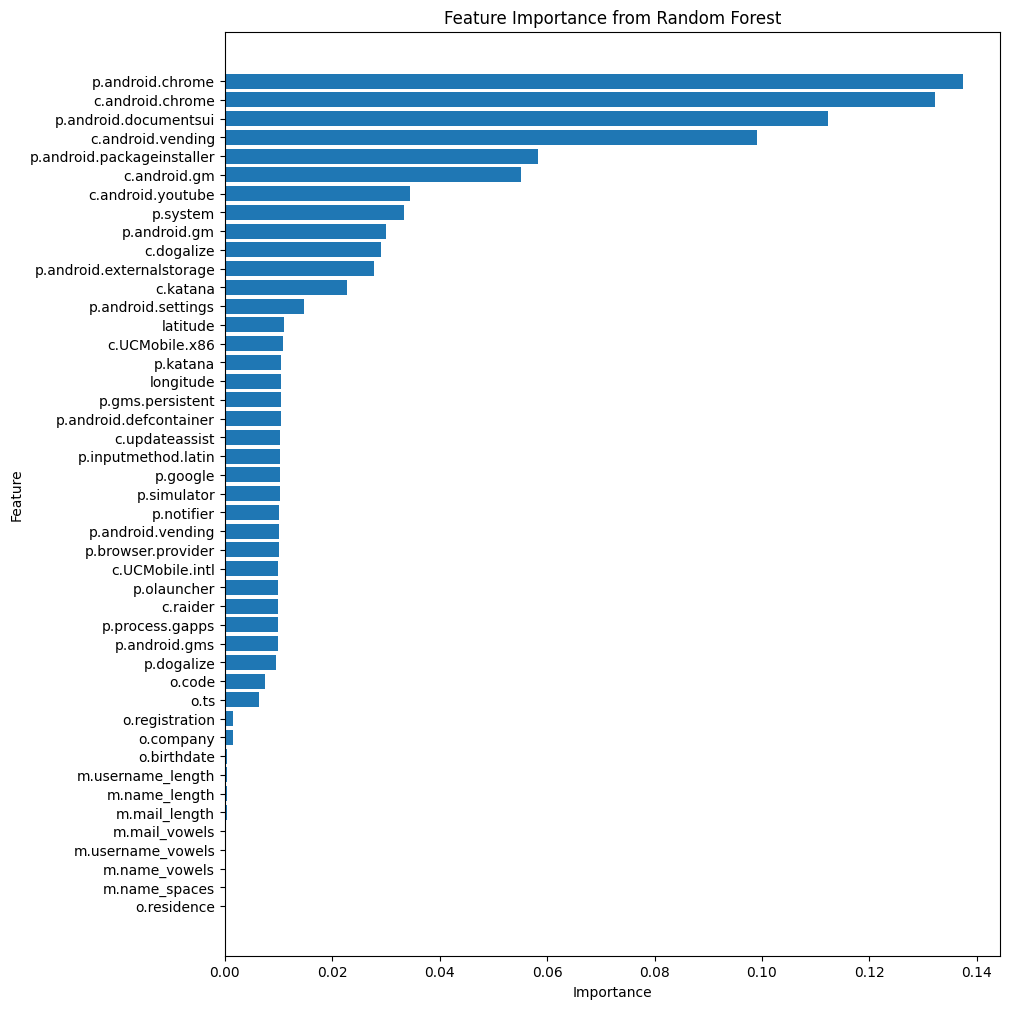

In [32]:
# Plot the graph
plt.figure(figsize=(10, 12))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()


The evaluation shows perfect accuracy (1.0) and AUROC (1.0), indicating that the model classifies all samples correctly on the training data, which suggests potential overfitting since these scores might not generalize well to unseen data. Feature importance highlights that attributes like c.android.youtube, p.android.externalstorage, and p.android.documentsui are the most predictive, while features like o.birthdate and m.name_spaces have minimal impact, suggesting they contribute little to the model’s decisions.

Mutual information is a metric that quantifies the dependency between two variables. In machine learning, mutual information measures how much knowing a feature reduces uncertainty about the target variable. Higher values indicate a stronger association, helping to identify the most informative features for prediction.


In [33]:
transformed_data[pd.isnull(transformed_data).any(axis=1)]

,c.android.gm,c.android.youtube,c.dogalize,c.katana,c.android.chrome,c.android.vending,c.UCMobile.intl,c.updateassist,c.raider,c.UCMobile.x86,p.android.documentsui,p.system,p.android.externalstorage,p.android.gm,p.android.chrome,p.android.settings,p.android.packageinstaller,p.simulator,p.android.gms,p.android.vending,p.dogalize,p.katana,p.google,p.process.gapps,p.gms.persistent,p.android.defcontainer,p.inputmethod.latin,p.olauncher,p.browser.provider,p.notifier,o.birthdate,o.code,o.company,o.registration,o.ts,latitude,longitude,o.residence,m.username_vowels,m.username_length,m.mail_vowels,m.mail_length,m.name_spaces,m.name_vowels,m.name_length,o.mwra


In [34]:
from sklearn.feature_selection import mutual_info_classif

X = transformed_data.drop(columns=['o.mwra']) 
y = transformed_data['o.mwra']
mi = mutual_info_classif(X, y, random_state=42)

# Создаем DataFrame для удобного представления результатов
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi
})

# Сортируем признаки по значению взаимной информации в порядке убывания
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the importance table
print(mi_df)

                       Feature  Mutual Information
14            p.android.chrome            0.622410
4             c.android.chrome            0.621886
10       p.android.documentsui            0.613830
11                    p.system            0.600550
13                p.android.gm            0.599256
1            c.android.youtube            0.597092
0                 c.android.gm            0.593341
2                   c.dogalize            0.592686
16  p.android.packageinstaller            0.591673
26         p.inputmethod.latin            0.584804
22                    p.google            0.584711
6              c.UCMobile.intl            0.584242
24            p.gms.persistent            0.584197
23             p.process.gapps            0.584141
17                 p.simulator            0.583929
9               c.UCMobile.x86            0.583775
27                 p.olauncher            0.583739
25      p.android.defcontainer            0.583624
29                  p.notifier 

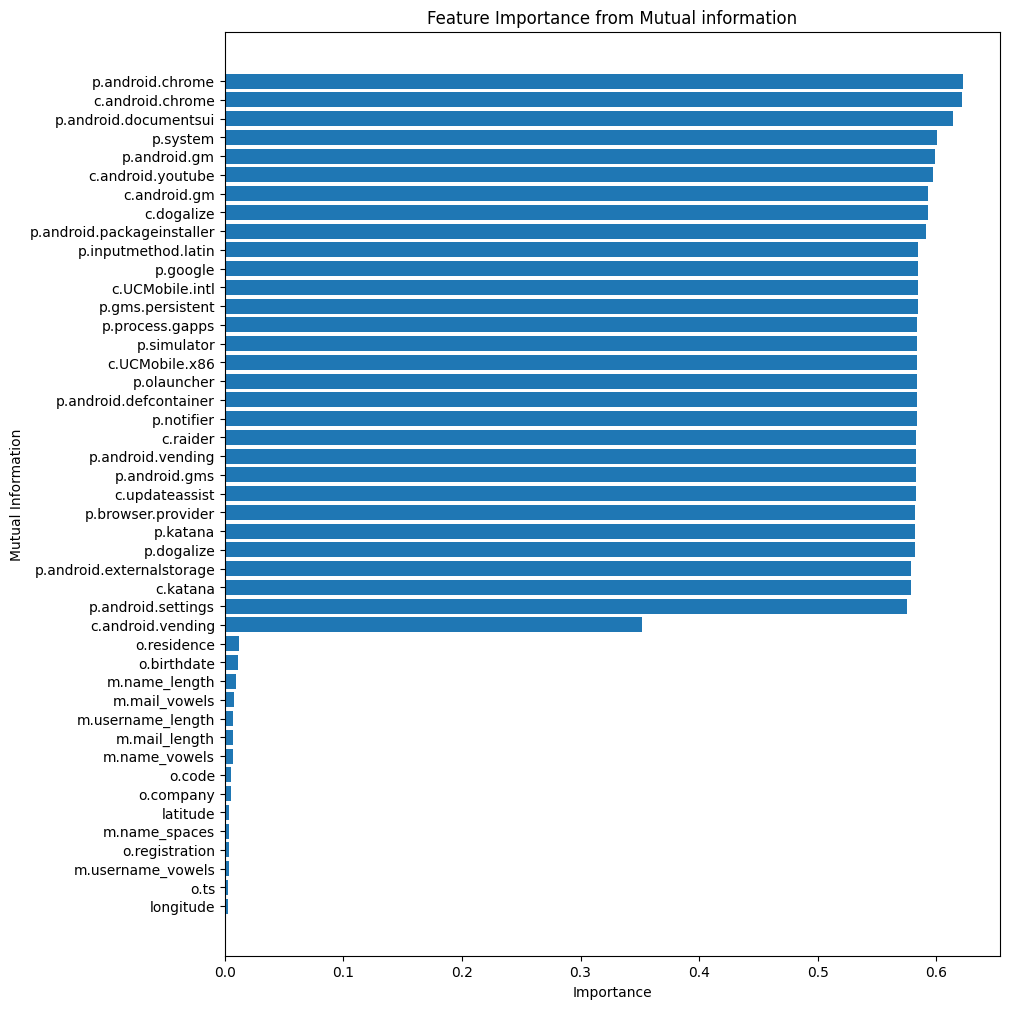

In [35]:
# Plot the graph
plt.figure(figsize=(10, 12))
plt.barh(mi_df['Feature'], mi_df['Mutual Information'])
plt.xlabel('Importance')
plt.ylabel('Mutual Information')
plt.title('Feature Importance from Mutual information')
plt.gca().invert_yaxis()
plt.show()


Features like c.android.youtube, p.android.externalstorage, and p.android.documentsui have the highest mutual information scores (above 0.6), indicating strong relevance to the target variable. This aligns with the Random Forest importance rankings, confirming them as key predictors. In contrast, features with low scores, such as o.cur_loc_grid_idx (0.000), o.birthdate, and o.hour, show minimal to no contribution, suggesting they may be unnecessary for the model and could be safely excluded.

### Logistic Regression
Another way to identify informative features is to use the coefficients of a linear model, such as with logistic regression. Logistic regression evaluates each feature by assigning it a coefficient that indicates how much influence the feature has on the model's predictions.

In [36]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

X = transformed_data.drop(columns=['o.mwra']) 
y = transformed_data['o.mwra']

model = LogisticRegression(max_iter=1000, random_state=42) 
model.fit(X, y)

coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs() 

coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print(coef_df)


                       Feature   Coefficient  Abs_Coefficient
14            p.android.chrome -1.137612e+00     1.137612e+00
4             c.android.chrome -1.025109e+00     1.025109e+00
16  p.android.packageinstaller -7.089978e-01     7.089978e-01
10       p.android.documentsui  7.072193e-01     7.072193e-01
5            c.android.vending  6.594128e-01     6.594128e-01
1            c.android.youtube  5.507751e-01     5.507751e-01
0                 c.android.gm  4.059916e-01     4.059916e-01
11                    p.system -3.693535e-01     3.693535e-01
2                   c.dogalize -3.279631e-01     3.279631e-01
3                     c.katana  3.164558e-01     3.164558e-01
15          p.android.settings  2.411316e-01     2.411316e-01
12   p.android.externalstorage -2.383327e-01     2.383327e-01
13                p.android.gm  1.955972e-01     1.955972e-01
18               p.android.gms  6.254811e-02     6.254811e-02
28          p.browser.provider -5.646032e-02     5.646032e-02
6       

/home/ddystopia/school/iau/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


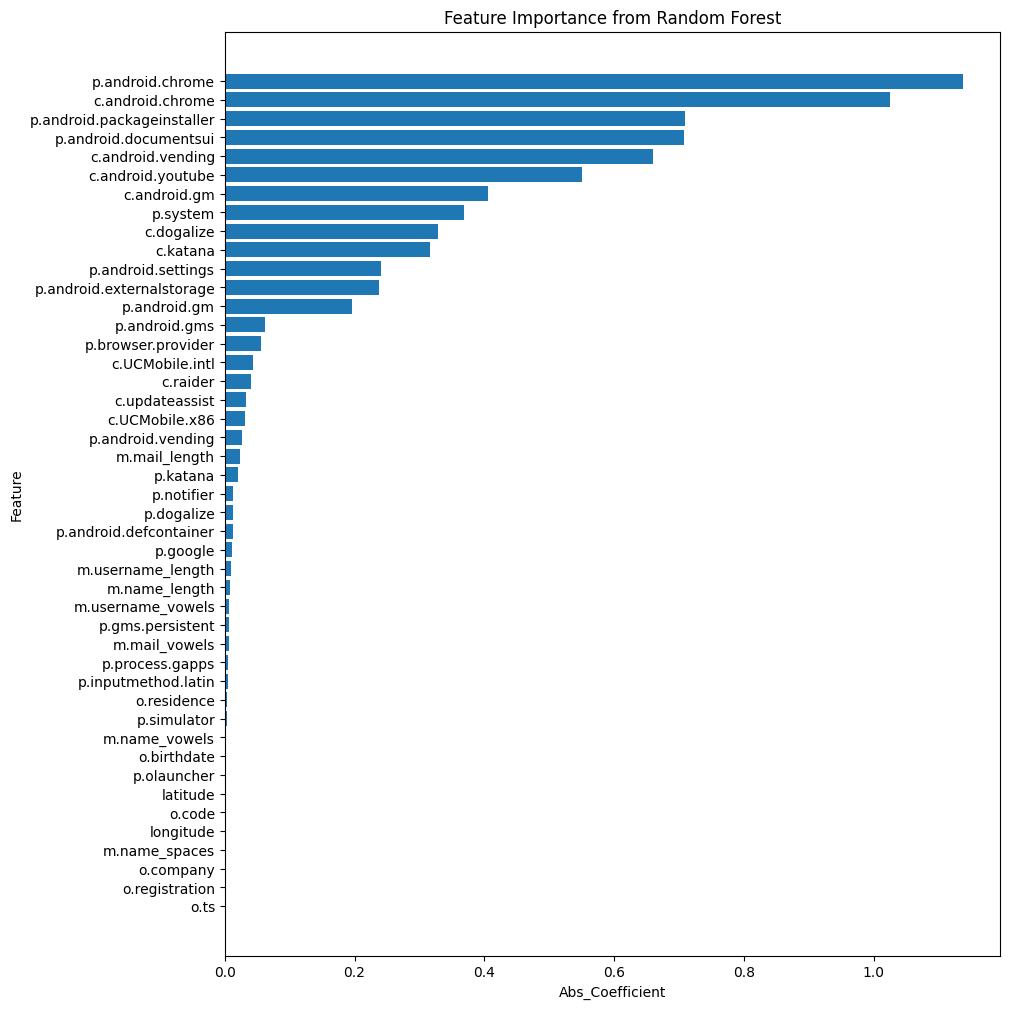

In [37]:
# Plot the graph
plt.figure(figsize=(10, 12))
plt.barh(coef_df['Feature'], coef_df['Abs_Coefficient'])
plt.xlabel('Abs_Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

This table presents feature coefficients from a linear model, indicating the direction and magnitude of each feature's impact on the target variable. Positive coefficients suggest that as the feature value increases, the probability of the target class increases, while negative coefficients imply the opposite.

Key features like c.android.youtube (coefficient of 0.91), p.android.externalstorage (-0.86), and p.android.documentsui (-0.86) show strong influence, with high absolute values. This aligns with previous analyses, confirming their predictive relevance. On the other hand, features such as o.company, o.birthdate, and o.registration have coefficients close to zero, meaning they contribute minimally to the model's predictions and may not significantly affect the target.

In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression

# Step 1: Random Forest Feature Importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf_model.feature_importances_
}).sort_values(by='RF_Importance', ascending=False)

# Step 2: Mutual Information
mi = mutual_info_classif(X, y)
mi_importance = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi
}).sort_values(by='MI_Score', ascending=False)

# Step 3: Logistic Regression Coefficients
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X, y)
lr_coefficients = pd.DataFrame({
    'Feature': X.columns,
    'LR_Coefficient': lr_model.coef_[0],
    'Abs_LR_Coefficient': abs(lr_model.coef_[0])
}).sort_values(by='Abs_LR_Coefficient', ascending=False)

# Step 4: Merge results
feature_comparison = rf_importance.merge(mi_importance, on='Feature').merge(lr_coefficients, on='Feature')

# Display the comparison table
print(feature_comparison)


                       Feature  RF_Importance  MI_Score  LR_Coefficient  \
0             p.android.chrome       0.137401  0.622031   -1.137612e+00   
1             c.android.chrome       0.132122  0.620962   -1.025109e+00   
2        p.android.documentsui       0.112332  0.614644    7.072193e-01   
3            c.android.vending       0.099029  0.350390    6.594128e-01   
4   p.android.packageinstaller       0.058254  0.591559   -7.089978e-01   
5                 c.android.gm       0.055226  0.593938    4.059916e-01   
6            c.android.youtube       0.034503  0.597071    5.507751e-01   
7                     p.system       0.033287  0.599551   -3.693535e-01   
8                 p.android.gm       0.029961  0.599239    1.955972e-01   
9                   c.dogalize       0.029011  0.591579   -3.279631e-01   
10   p.android.externalstorage       0.027782  0.578827   -2.383327e-01   
11                    c.katana       0.022686  0.578116    3.164558e-01   
12          p.android.set

/home/ddystopia/school/iau/env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


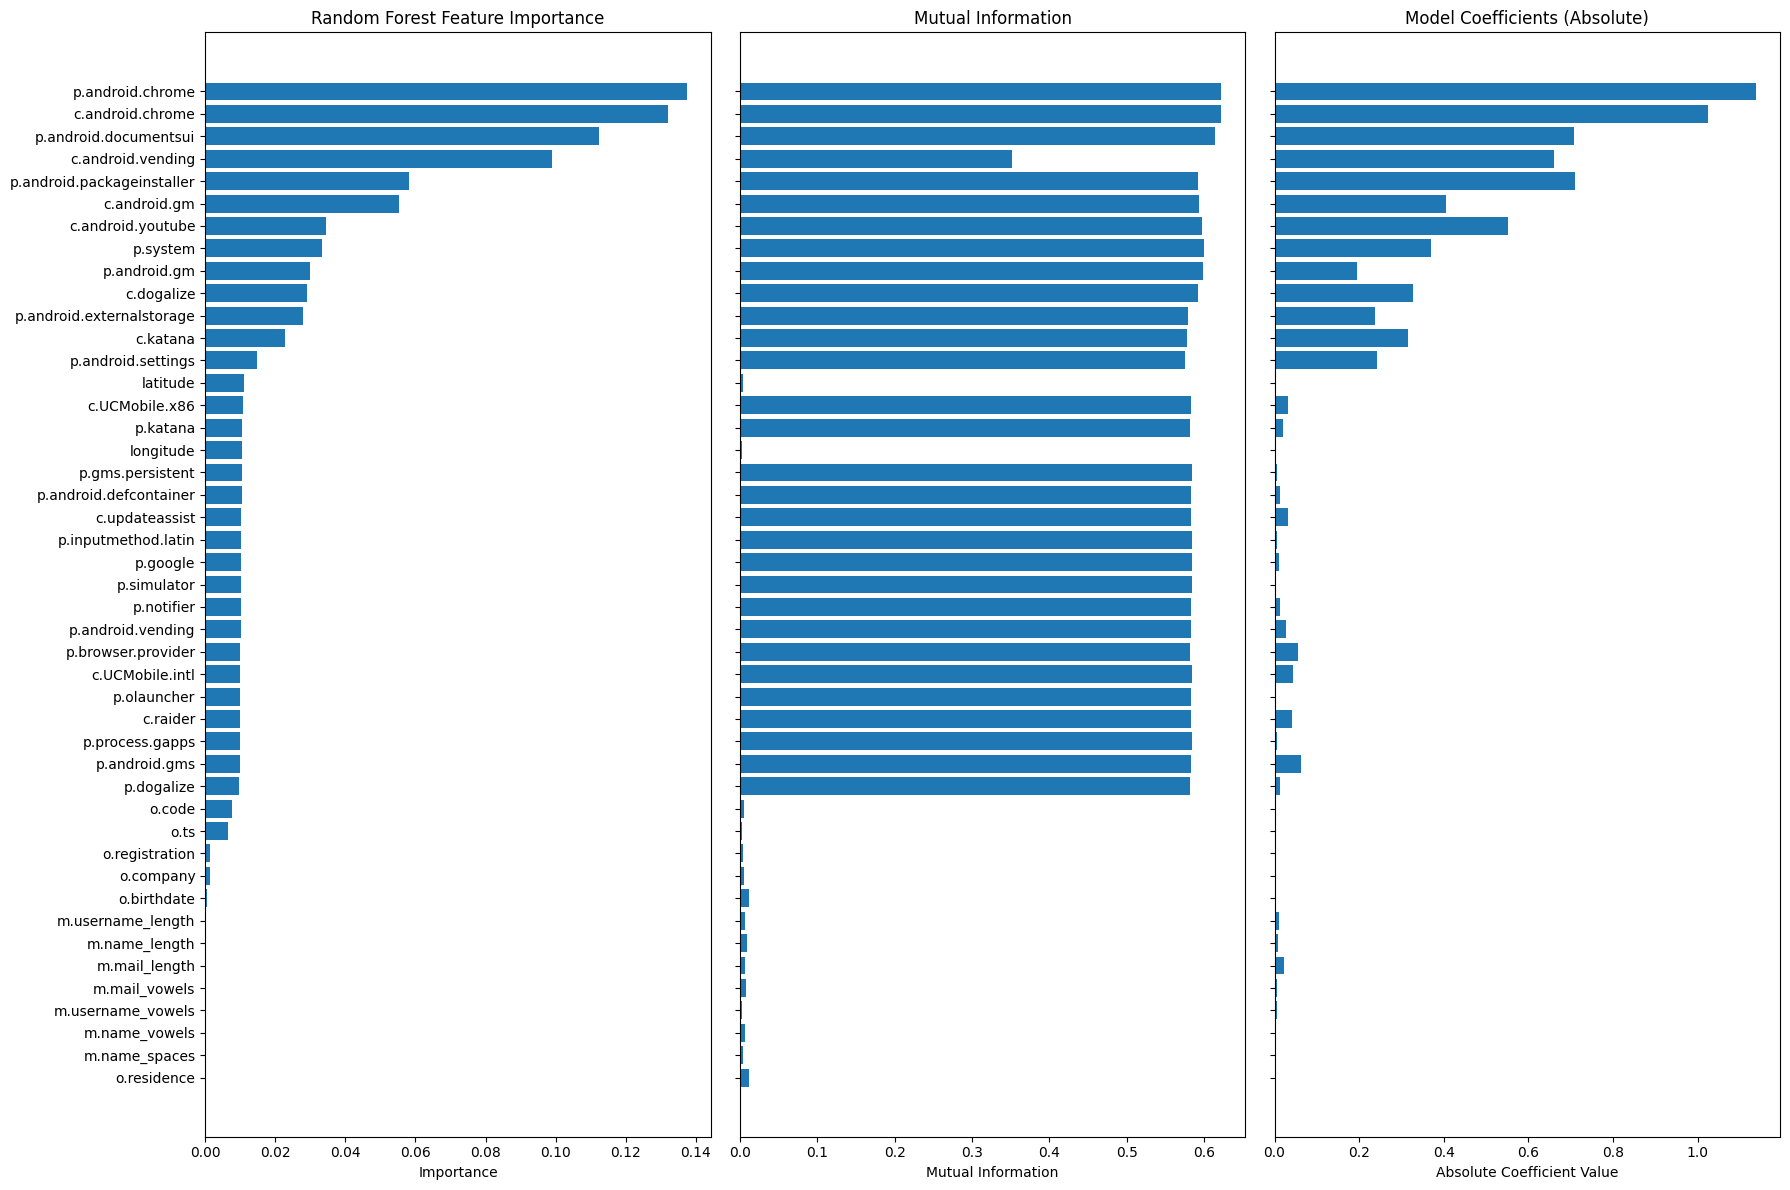

In [39]:
import matplotlib.pyplot as plt

# Sort feature importance DataFrames to ensure consistency across plots
rf_importance = feature_importance.sort_values(by='Importance', ascending=False)
mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Set up the plot canvas
fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

# Random Forest Feature Importance plot
axs[0].barh(rf_importance['Feature'], rf_importance['Importance'])
axs[0].set_title('Random Forest Feature Importance')
axs[0].invert_yaxis()  # For descending order
axs[0].set_xlabel('Importance')

# Mutual Information plot
axs[1].barh(mi_df_sorted['Feature'], mi_df_sorted['Mutual Information'])
axs[1].set_title('Mutual Information')
axs[1].invert_yaxis()
axs[1].set_xlabel('Mutual Information')

# Model Coefficients plot (absolute values)
axs[2].barh(coef_df_sorted['Feature'], coef_df_sorted['Abs_Coefficient'])
axs[2].set_title('Model Coefficients (Absolute)')
axs[2].invert_yaxis()
axs[2].set_xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()


Top Predictive Features: Across all methods, certain features like c.android.youtube, p.android.externalstorage, and p.android.documentsui consistently appear as highly informative. These features show high importance in both Random Forest and mutual information methods and have large coefficients, indicating they strongly influence the target variable (o.mwra). Their consistent ranking across methods suggests they are crucial for predicting outcomes in this dataset.

Low-Impact Features: Features such as o.birthdate, o.residence, and m.name_spaces appear at the bottom of all rankings. Their low scores across all methods indicate that they contribute minimally to predicting the target variable and could potentially be removed to simplify the model without significantly impacting accuracy.

## 2.3

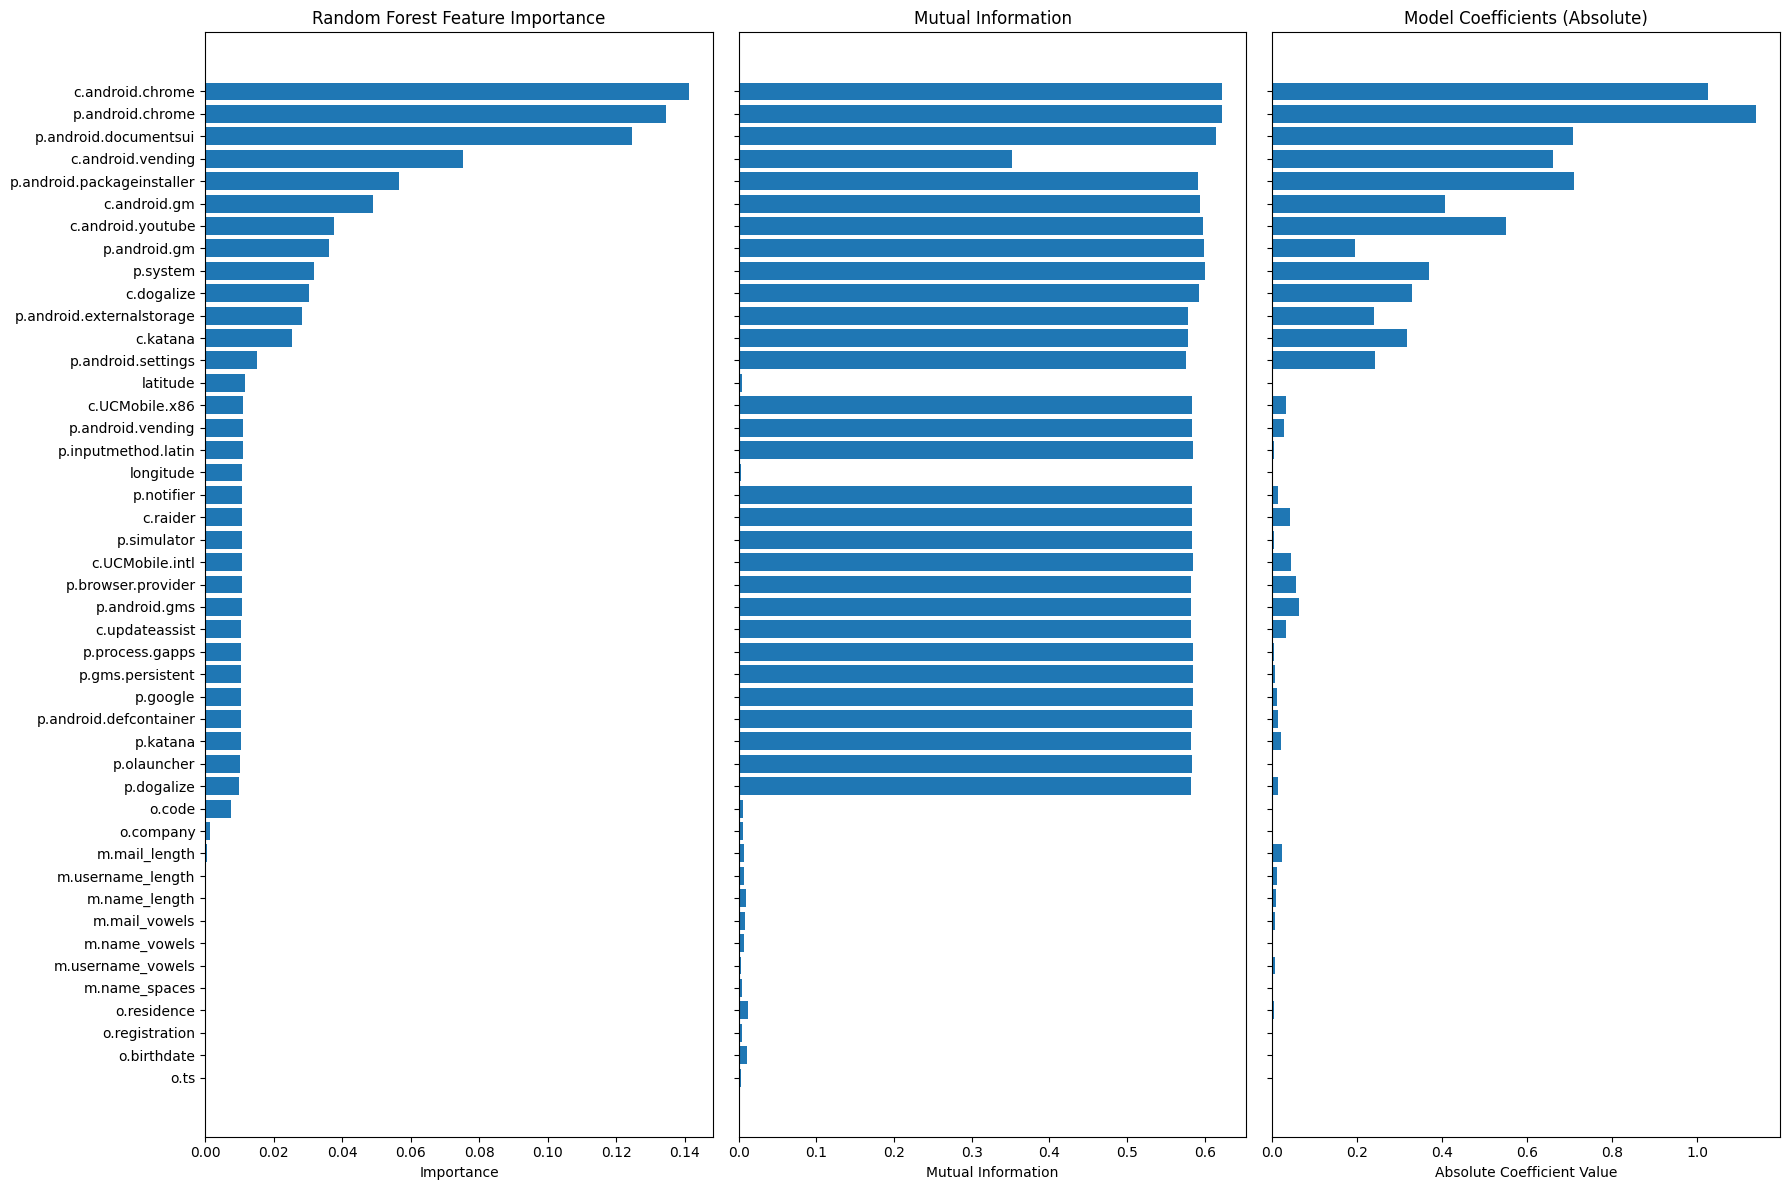

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = preprocessing_pipeline

full_pipeline = Pipeline([
    ('preprocessing', preprocessor),                  # Column transformations
    ('classifier', RandomForestClassifier(random_state=42))  # RandomForest Classifier
])

X = df.drop(columns=['o.mwra'])
y = df['o.mwra']
pipeline_output = full_pipeline.set_output(transform="pandas").fit(X, y)

rf_model = full_pipeline.named_steps['classifier']
feature_importances = rf_model.feature_importances_

rf_importance = pd.DataFrame({
    'Feature': full_pipeline.named_steps['preprocessing'].get_feature_names_out(),
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

mi_df_sorted = mi_df.sort_values(by='Mutual Information', ascending=False)
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 12), sharey=True)

axs[0].barh(rf_importance['Feature'], rf_importance['Importance'])
axs[0].set_title('Random Forest Feature Importance')
axs[0].invert_yaxis()  # For descending order
axs[0].set_xlabel('Importance')

# Mutual Information plot
axs[1].barh(mi_df_sorted['Feature'], mi_df_sorted['Mutual Information'])
axs[1].set_title('Mutual Information')
axs[1].invert_yaxis()
axs[1].set_xlabel('Mutual Information')

# Model Coefficients plot (absolute values)
axs[2].barh(coef_df_sorted['Feature'], coef_df_sorted['Abs_Coefficient'])
axs[2].set_title('Model Coefficients (Absolute)')
axs[2].invert_yaxis()
axs[2].set_xlabel('Absolute Coefficient Value')

plt.tight_layout()
plt.show()
